In [262]:
# set-up -- do not change
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
npr.seed(1)

# Question 2.1 (7 pts)

> This question is about computing the total (root mean squared) error (RMSE) for a Bayesian observer, as seen in Week 3 of the course. The take-home message here is that the Bayesian observer whose prior matches the true empirical distribution of stimuli will perform best at the task (lower RMSE), compared to a Bayesian observer with an incorrect (aka *mismatched*) belief about the distribution of stimuli (i.e., whose prior does not match the true stimulus distribution). See Chapter 4.5 of \[**MKG23**\] and the lecture notes for Week 3.

A Bayesian observer is estimating a stimulus with empirical distribution $p(s) = \text{Uniform}(s; -5, 5)$.
The measurement distribution and likelihood are Gaussian $p(x|s) = \mathcal{N}\left(x; s, \sigma^2 \right)$ with $\sigma = 2$.
We assume that the observer uses the posterior mean estimator $\hat{s}_{PM}$ and we ignore response noise. However, we consider the observer uses as prior a distribution $q(s)$ which might differ from the true prior (mismatched prior).

- a) Compute the total RMSE assuming $q(s) = p(s)$, i.e. the observer uses the true stimulus distribution as prior.
- b) Compute the total RMSE assuming the observer uses an approximate Gaussian prior, $q(s) = \mathcal{N}\left(s; \mu_s, \sigma_s^2 \right)$ with mean $\mu_s$ and variance $\sigma^2_s$ equal to the mean and variance of the true stimulus distribution. *Hint*: You can find the variance of a continuous uniform distribution [here](https://en.wikipedia.org/wiki/Continuous_uniform_distribution).
- c) Compute the total RMSE assuming the observer uses as prior a mismatched, wider Uniform distribution, $q(s) = \text{Uniform}\left(s; -8, 8 \right)$.

Report your results in Moodle. The accepted tolerance is $\pm 0.01$ from the true value.

*Hints*: 
- Remember that the (total) RMSE of an estimator $\hat{s}$ is computed as
$$
\text{RMSE}[\hat{s}] = \sqrt{\int \text{MSE}\left[\hat{s}|s\right] p(s) ds}
$$
  where $p(s)$ is the true empirical distribution and $\text{MSE}\left[\hat{s}|s\right]$ is the mean squared error at each stimulus, defined as
$$
\text{MSE}\left[\hat{s}|s\right] = \mathbb{E}_{\hat{s}|s}\left[\left(\hat{s}-s\right)^2|s \right] = \text{Bias}\left[\hat{s}|s\right]^2 + \text{Var}\left[\hat{s}|s\right],
$$
  where the definitions for bias and variance can be found in the textbook or lecture notes.
- Note that changing the prior $q(s)$ will change $\hat{s}(x)$, but nothing else! So once you manage to compute (a), you should be able to compute (b) and (c) with a small change to the code (only where $\hat{s}(x)$ is computed).
- You may want to check out Exercise 3.3 of the workshops.

In [2]:
# Problem parameters
a = -5
b = 5
sigma = 2

Nx = 2**9+1
Ns = 2**9+1
lb = a - sigma*5.
ub = b + sigma*5.
x_row = np.linspace(lb, ub, Nx).reshape((1,Nx)) 
s_col = np.linspace(lb, ub, Ns).reshape((Ns,1)) 
dx = x_row.flatten()[1] - x_row.flatten()[0]
ds = s_col.flatten()[1] - s_col.flatten()[0]

# Function to compute posterior mean
def posterior_mean(s_grid, prior_pdf, likelihood):
    ds = s_grid.flatten()[1] - s_grid.flatten()[0] # grid spacing
    protoposterior = prior_pdf * likelihood    
    normalization_constant = sp.integrate.romb(protoposterior, dx=ds, axis=0)
    posterior_pdf = protoposterior / normalization_constant
    posterior_mean = sp.integrate.romb(s_grid * posterior_pdf, dx=ds, axis=0)
    return posterior_mean

# Function to compute metrics
def compute_metrics(s_col, s_hat, stimulus_pdf, label):
    bias = sp.integrate.romb(s_hat * sps.norm.pdf(x_row,s_col,sigma),dx=dx,axis=1) - s_col.flatten()
    std = np.sqrt(sp.integrate.romb(s_hat**2 * sps.norm.pdf(x_row,s_col,sigma),dx=dx,axis=1) 
        - sp.integrate.romb(s_hat * sps.norm.pdf(x_row,s_col,sigma),dx=dx,axis=1)**2)
    rmse = np.sqrt(bias**2 + std**2)
    total_rmse = np.sqrt(sp.integrate.romb(rmse**2 * stimulus_pdf,dx=ds))
    print('Total RMSE (' + label + '): {}'.format(total_rmse))

# Compute s_hat for all values of x on the grid
prior_pdf = sps.uniform.pdf(s_col, a, b-a)
likelihood = sps.norm.pdf(x_row, s_col, sigma) 
s_hat_row = posterior_mean(s_col, prior_pdf, likelihood).reshape((1,Nx)) 

# Compute and print total 
print('a):')
stimulus_pdf = prior_pdf.copy().flatten() 
compute_metrics(s_col, s_hat_row, stimulus_pdf, 'True Prior')

# Compute s_hat for Gaussian prior
mu_s = (a + b) / 2
sigma_s = np.sqrt((b - a)**2 / 12)
prior_pdf = sps.norm.pdf(s_col, mu_s, sigma_s)
s_hat_row = posterior_mean(s_col, prior_pdf, likelihood).reshape((1,Nx)) 

# Compute total RMSE
print('b):')
compute_metrics(s_col, s_hat_row, stimulus_pdf, 'Gaussian Prior')

# Compute s_hat for mismatched Uniform prior
a_mismatched = -8
b_mismatched = 8
prior_pdf = sps.uniform.pdf(s_col, a_mismatched, b_mismatched - a_mismatched)
s_hat_row = posterior_mean(s_col, prior_pdf, likelihood).reshape((1,Nx)) 

# Compute and print total RMSE
print('c):')
compute_metrics(s_col, s_hat_row, stimulus_pdf, 'Mismatched Uniform Prior')


a):
Total RMSE (True Prior): 1.6048573201415854
b):
Total RMSE (Gaussian Prior): 1.6507353124849051
c):
Total RMSE (Mismatched Uniform Prior): 1.826123175925474


# Question 2.2 (6 pts)

> The key quantity for model fitting is the log-likelihood for a dataset and some model parameters. In this exercise, we compute the log-likelihood for a Bayesian observer model which also includes the possibility of *lapses*, a common mechanism used in cognitive science to explain away "random" responses and subjects' mistakes.

In this question, we consider the datasets from Experiment 3 of \[**AWV12**\], as seen in Week 4.. The experimental setup which involves time perception and interval reproduction is very similar to \[**JS10**\], so we can consider the same type of models.

We analyze the data with the `gaussianobserverwithlapse` model, defines as follows:

- We assume the observer builds a (mismatched) Gaussian prior $p(s) = \mathcal{N}\left(s| \mu_\text{prior}, \sigma_\text{prior}^2 \right)$ over the stimuli (time intervals). 
- We assume that the measurement distribution and likelihood are also Gaussian, $p(x|s) = \mathcal{N}\left(x| s, \sigma^2 \right)$.
- The observer uses the *posterior mean* estimator for the value of the stimulus, $\hat{s}_\text{PM}$.
- Gaussian motor response noise is added to the estimate, $p(r|\hat{s}) = \mathcal{N}\left(r| \hat{s}, \sigma_\text{motor}^2 \right)$.
- In each trial, the observer lapses with probability $\lambda$ (the *lapse rate*), in which case the response is drawn from $p_\text{lapse}(r) = \text{Uniform}\left(r; 0, 1500 \right)$ ms. Otherwise, the observer responds normally (according to $p(r|\hat{s})$ described above) with probability $1 - \lambda$. 
- The parameters of this model are $\mathbf{\theta} = \left(\mu_\text{prior}, \sigma_\text{prior}, \sigma, \sigma_\text{motor}, \lambda \right)$.

For this question, we consider parameters $\mathbf{\theta}_\star = \left(\mu_\text{prior} = 780, \sigma_\text{prior} = 140, \sigma = 90, \sigma_\text{motor} = 60, \lambda = 0.02 \right)$. 

- a) Compute the log-likelihood of model parameter $\theta_\star$ for the dataset of subject 2.
- b) Compute the log-likelihood of model parameter $\theta_\star$ for the dataset of subject 5.

Report your results on Moodle with high precision.

*Hint*:
- If you use code from the lectures, be careful about the model definition, as there may be subtle differences.

In [222]:
# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/lacerbi/prob-cog-mod-files/main/data/awv12_exp3.csv')

# Remove unused columns (they deal with performance feedback, which we ignore in this lecture)
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

df.head()

,Subject id,Session id,Run id,Stimulus (ms),Response (ms),Stimulus id
0,1,1,1,973.327049,862.947945,6.0
1,1,1,1,677.519900,574.920276,2.0
2,1,1,1,826.253049,870.995615,4.0
3,1,1,1,677.854859,695.055098,2.0
4,1,1,1,598.501198,632.981845,1.0


s.shape: (2520,)
r.shape: (2520,)


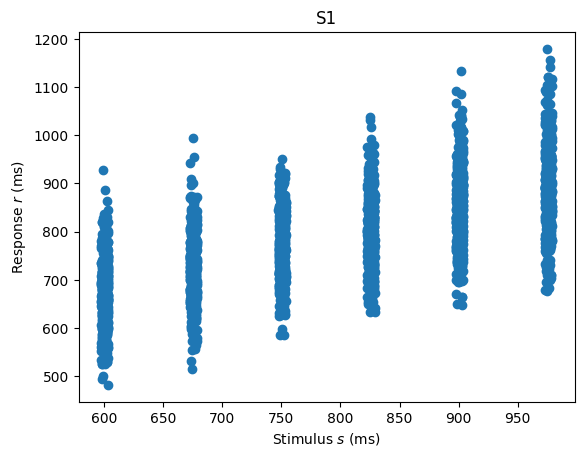

In [174]:
# Example code to extract stimuli and responses for a single subject (here S1)
subject = 1
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])
print('s.shape:', s.shape)
print('r.shape:', r.shape)

plt.scatter(s, r)
plt.xlabel('Stimulus $s$ (ms)')
plt.ylabel('Response $r$ (ms)')
plt.title('S' + str(subject))
plt.show()

In [219]:
def gaussian_response(s, theta):
    mu_prior, sigma_prior, sigma, sigma_motor = theta[:4]
    w = sigma_prior**2 / (sigma_prior**2 + sigma**2)
    mu_resp = w * s + (1 - w) * mu_prior
    sigma_resp = np.sqrt(w**2 * sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

def idealgaussianobserver_loglike_with_lapse(theta, s_vec, r_vec):
    lambda_lapse = theta[-1]
    mu_prior, sigma_prior, sigma, sigma_motor = theta[:4]
    
    mu_resp, sigma_resp = gaussian_response(s_vec, np.array((mu_prior, sigma_prior, sigma, sigma_motor)))
    
    gaussian_loglike_vec = sps.norm.logpdf(r_vec, mu_resp, sigma_resp)
    
    lapse_loglike = np.log(lambda_lapse) + np.log(1 / 1500)
    
    total_loglike_vec = np.log((1 - lambda_lapse) * np.exp(gaussian_loglike_vec) + np.exp(lapse_loglike))
    
    total_loglike = np.sum(total_loglike_vec)
    
    return total_loglike

# Model parameters
theta_star = np.array([780, 140, 90, 60, 0.02])

# Compute log-likelihood for Subject 2
s2 = df['Stimulus (ms)'][df['Subject id'] == 2].values
r2 = df['Response (ms)'][df['Subject id'] == 2].values
loglike_sub2 = idealgaussianobserver_loglike_with_lapse(theta_star, s2, r2)
print(f'Log-likelihood for Subject 2: {loglike_sub2:.15f}')

# Compute log-likelihood for Subject 5
s5 = df['Stimulus (ms)'][df['Subject id'] == 5].values
r5 = df['Response (ms)'][df['Subject id'] == 5].values
loglike_sub5 = idealgaussianobserver_loglike_with_lapse(theta_star, s5, r5)
print(f'Log-likelihood for Subject 5: {loglike_sub5:.15f}')

Log-likelihood for Subject 2: -8577.318546123511624
Log-likelihood for Subject 5: -9105.655523964238455


# Question 2.3 (6 pts)

> When fitting models to data, the experimenter may be interested in how model parameters are represented across the population (here represented by the group of subjects). A simple way to look at this is to look at the distribution of maximum-likelihood estimates for the parameters across subjects, in first instance by looking their mean and variability.

We consider here the `idealgaussianobserverwithlapse` model. This model is the same as the `gaussianobserverwithlapse` of Question 2.3, but with $\mu_\text{prior} = 787.5$ ms and $\sigma_\text{prior} = 128.1$ ms fixed. Thus, the model has three free parameters, $\theta = \left(\sigma, \sigma_\text{motor}, \lambda \right)$. Fit the model using maximum-likelihood estimation.

- a) First, fit the `idealgaussianobserverwithlapse` model to the six subjects' datasets (separately for each subject's data). For each maximum-likelihood estimate (MLE) of parameters $\sigma, \sigma_\text{motor}, \lambda$, report in Moodle the mean and standard deviation across the six subjects. For the standard deviation, use the correction for degrees of freedom (that is, `np.std(..., ddof=1)`).
- b) Now fit the pooled data of all subjects as a single dataset (as if all data were collected from a single uber-subject). Report the maximum-likelihood estimate of $\sigma, \sigma_\text{motor}, \lambda$ for the pooled data in Moodle.

*Hints*: 
- If you use code for the `idealgaussianobserverwithlapse` model from the lectures, be careful about the model definition.
- As a sanity check that you have coded the log-likelihood function correctly, check that the log-likelihood of the dataset of subject 1 for $\theta_\star = \left(\sigma = 90, \sigma_\text{motor} = 80, \lambda = 0.02\right)$ is $\log \mathcal{L}(\theta_\star; \mathcal{D}_1) \approx -14709.795\ldots$

*Note*: Fitting individual subjects' data is the best approach to describe invidual behavior in cognitive science, but sometimes you will see studies only looking at pooled/group data. Be careful that pooling might hide what really happens, only giving a snapshot of the average behavior of the group, which might not correspond to what individuals do.

In [247]:
def gaussian_response(s, theta):
    # Fixed prior values
    mu_prior = 787.5
    sigma_prior = 128.1
    # Extract sigma and sigma_motor from theta
    sigma, sigma_motor = theta[:2]
    w = sigma_prior**2 / (sigma_prior**2 + sigma**2)
    mu_resp = w * s + (1 - w) * mu_prior
    sigma_resp = np.sqrt(w**2 * sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

def idealgaussianobserver_loglike_with_lapse(theta, s_vec, r_vec):
    lambda_lapse = theta[-1]
    sigma, sigma_motor = theta[:2]
    
    mu_resp, sigma_resp = gaussian_response(s_vec, np.array((sigma, sigma_motor)))
    
    gaussian_loglike_vec = sps.norm.logpdf(r_vec, mu_resp, sigma_resp)
    
    lapse_loglike = np.log(lambda_lapse) + np.log(1 / 1500)
    
    total_loglike_vec = np.log((1 - lambda_lapse) * np.exp(gaussian_loglike_vec) + np.exp(lapse_loglike))
    
    total_loglike = np.sum(total_loglike_vec)
    
    return total_loglike

# Assuming df is your DataFrame containing the data for all subjects
theta_star = np.array([90, 80, 0.02])  # New theta structure

# Extract data for Subject 1
s1 = df['Stimulus (ms)'][df['Subject id'] == 1].values
r1 = df['Response (ms)'][df['Subject id'] == 1].values

# Compute log-likelihood for Subject 1
loglike_sub1 = idealgaussianobserver_loglike_with_lapse(theta_star, s1, r1)
print(f'Log-likelihood for Subject 1: {loglike_sub1:.15f}')


Log-likelihood for Subject 1: -14709.795433871162459


In [250]:
use_pybads = True
if use_pybads:
    from pybads.bads import BADS
    method = 'BADS'
else:
    method = 'L-BFGS-B'

In [256]:
def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs=3,method='L-BFGS-B'):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)
        
        if method == 'L-BFGS-B':
            bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
            res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
            nll_res[index] = res.fun
            theta_res[index] = res.x
        elif method == 'BADS':
            bads = BADS(target_fun, theta0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds)
            res = bads.optimize()
            nll_res[index] = res.fval
            theta_res[index] = res.x
        else:
            error('Unknown optimization method.')
        print('Run {}: log-likelihood {}'.format(index, -nll_res[index]))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best

In [257]:
lower_bounds = np.array([1., 1., 0.])
upper_bounds = np.array([2000., 2000., 1.])
plausible_lower_bounds = np.array([10., 10., 0.01])
plausible_upper_bounds = np.array([100., 100., 0.1])

# Optimization and statistics collection
results = []  # To store the best-fit parameters for each subject

for subject in range(1, 7):  # Loop over subjects
    s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
    r = np.array(df['Response (ms)'][df['Subject id'] == subject])
    # Make sure theta_ is used correctly in the lambda function
    target_fun = lambda theta_: -idealgaussianobserver_loglike_with_lapse(theta_, s, r)

    # Call the optimization function
    nll_best, theta_best = multioptimize(target_fun, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs=3, method='BADS' if 'BADS' in globals() else 'L-BFGS-B')

    results.append(theta_best)
    print(f'Subject {subject}: Best-fit parameters: {theta_best}, NLL: {nll_best}')

# Convert results to a numpy array for easier analysis
results_array = np.array(results)

# Compute mean and standard deviation across subjects for each parameter
means = np.mean(results_array, axis=0)
std_devs = np.std(results_array, axis=0, ddof=1)

print("Mean parameter values across subjects:", means)
print("Standard deviation of parameter values across subjects:", std_devs)

Variables (index) internally transformed to log coordinates: [[0 0]
 [0 1]]
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         14844.7               1                                 Uncertainty test
     0           6         14757.2               1         Initial mesh            Initial points
     0          12         14670.2               1       Successful poll           Train
     1          16           14616               1     Successful search (ES-wcm)        
     1          24         14538.1               1       Successful poll           
     2          27         14515.6               1     Successful search (ES-ell)        
     2          29         14500.7               1     Successful search (ES-ell)        
     2          30         14497.7               1     Successful search (ES-ell)        
     2          32         14497.4      

In [258]:
# Assuming 'df' is your DataFrame containing the data for all subjects
# Combine all stimulus and response data across subjects
all_s = df['Stimulus (ms)'].values
all_r = df['Response (ms)'].values

# Define the optimization target function using the combined data
target_fun_all = lambda theta: -idealgaussianobserver_loglike_with_lapse(theta, all_s, all_r)

# Define the bounds for the parameters as before
lower_bounds = np.array([1., 1., 0.])
upper_bounds = np.array([2000., 2000., 1.])
plausible_lower_bounds = np.array([10., 10., 0.01])
plausible_upper_bounds = np.array([100., 100., 0.1])

# Run the optimization for the combined data
nll_best_all, theta_best_all = multioptimize(target_fun_all, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs=3, method='BADS' if 'BADS' in globals() else 'L-BFGS-B')

# Report the MLE of parameters for the pooled data
print(f"MLE of parameters for the pooled data: \sigma={theta_best_all[0]:.2f}, \sigma_motor={theta_best_all[1]:.2f}, \lambda={theta_best_all[2]:.4f}, NLL: {nll_best_all}")


Variables (index) internally transformed to log coordinates: [[0 0]
 [0 1]]
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         61061.8               1                                 Uncertainty test
     0           6         60466.4               1         Initial mesh            Initial points
     0          12         60204.7               1       Successful poll           Train
     1          21         60204.7             0.5         Refine grid             Train
     2          24         60136.1             0.5     Successful search (ES-wcm)        
     2          34         60133.4               1       Successful poll           Train
     3          43         60133.4             0.5         Refine grid             Train
     4          44         60091.5             0.5     Successful search (ES-ell)        
     4          47         60068.1   